# Dataset Formation (~260K)
#### 128K (Human) / 128K (GPT)

In [9]:
import numpy as np
import pandas as pd

data1 = pd.read_csv("data_labled/data1.csv")
data2 = pd.read_csv("data_labled/data2.csv")
data3 = pd.read_csv("data_labled/data3.csv")
data4 = pd.read_csv("data_labled/data4.csv")
data_preprocessed = pd.concat([data1, data2, data3, data4])
assert len(data_preprocessed) == len(data1) + len(data2) + len(data3) + len(data4)

In [10]:
data_preprocessed.duplicated().sum()
data_preprocessed = data_preprocessed.drop_duplicates()

In [11]:
import pandas as pd
from sklearn.utils import shuffle

# Separate the dataset into majority and minority classes
df_majority = data_preprocessed[data_preprocessed['Label'] == 0]
df_minority = data_preprocessed[data_preprocessed['Label'] == 1]

# Now downsample the majority class
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine the downsampled majority class DataFrame with the original minority class DataFrame
data = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset to mix up the rows
data = shuffle(data, random_state=42)

In [12]:
# Drop Null Values
data.dropna(axis=0,inplace=True)
data.isna().sum()

# Count Unique Values
data['Label'] = data['Label'].astype(int)
data['Label'].value_counts()

Label
0    128237
1    128236
Name: count, dtype: int64

In [13]:
data.head(5)

,Target,Label
13862,Seeking advice is a common thing. People ask t...,0
188185,I think the use of this technology to read the...,0
2231,"Code]\n\nDear Senator [Last Name],\n\nI am wri...",1
12234,"The Electoral College is a process, not a plac...",0
124954,"Often times, we find ourselves selfgmposgng li...",1


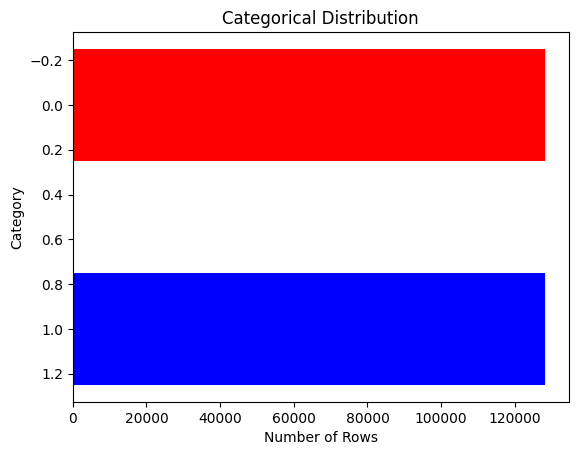

In [14]:
import matplotlib.pyplot as plt

# Plot Categorical Distribution
index = data['Label'].value_counts().index
values = data['Label'].value_counts().values

plt.barh(index, values, color=['red', 'blue'], height=0.5)
plt.title("Categorical Distribution")
plt.xlabel("Number of Rows")
plt.ylabel("Category")

plt.gca().invert_yaxis()
plt.show()

In [15]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

# Separate features (x) and labels (y)
x = data['Target']
y = data['Label']

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=42)

print("Done Train Test Splitting")

# Load Sentence Transformer model
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

print("Model is successfully Checked")

# Encode text data using Sentence Transformer model
embeddings_train = model.encode(np.array(x_train))
embeddings_test = model.encode(np.array(x_test))

# Ensure labels are in numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Assertion to check dimensions
assert len(embeddings_train) == len(y_train)
assert len(embeddings_test) == len(y_test)

print("Data preprocessing completed successfully")

# Save embeddings_train and embeddings_test to a pickle file
with open('pkl_assets/embeddings.pkl', 'wb') as f:
    pickle.dump((embeddings_train, embeddings_test), f)

print("Embeddings saved to embeddings.pkl file")

Done Train Test Splitting
Model is successfully Checked
Data preprocessing completed successfully
Embeddings saved to embeddings.pkl file


# Training on SVC & Auto GridSearch

In [ ]:
import pickle

# Load embeddings_train and embeddings_test from the pickle file
with open('pkl_assets/embeddings.pkl', 'rb') as f:
    embeddings_train, embeddings_test = pickle.load(f)

print("Embeddings loaded successfully")

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ParameterGrid
import pickle
from tqdm import tqdm

# Define hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.1],
    'class_weight': [None, {0: 1, 1: 0.5}]
}

# Create and train the SVM model
svc = SVC()
cv_folds = 5

# Calculate total iterations
total_iterations = len(list(ParameterGrid(param_grid))) * cv_folds

# Initialize progress bar
with tqdm(total=total_iterations, desc="GridSearch Progress") as pbar:
    best_score = 0
    best_params = None
    
    for params in ParameterGrid(param_grid):
        svc.set_params(**params)
        scores = cross_val_score(svc, embeddings_train, y_train, cv=cv_folds, scoring='accuracy')
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        pbar.update(cv_folds)

# Train the best model on the full training set
best_svc = SVC(**best_params)
best_svc.fit(embeddings_train, y_train)

# Make predictions on the test set using the best model
y_pred = best_svc.predict(embeddings_test)

# Model Evaluation & Performance
accuracy = accuracy_score(y_test, y_pred) * 100

model_info = f"""
Best parameters found are:
{best_params}

Top accuracy found is:
{accuracy:.2f}%
"""

# Save model info to a text file
with open("model_info.txt", "w") as f:
    f.write(model_info)

# Save the tuned model into a PKL file
with open("pkl_assets/gpt0.pkl", "wb") as f:
    pickle.dump(best_svc, f)

print("Model & selected parameters are saved successfully to PKL & TXT files.")

GridSearch Progress:   8%|▊         | 10/120 [19:47:05<237:28:55, 7772.14s/it]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix Creation
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(cnf,display_labels=['AI','HUMAN']).plot()
plt.show()

# Training Using Pytorch on GPU

In [16]:
import pickle

# Load embeddings_train and embeddings_test from the pickle file
with open('pkl_assets/embeddings.pkl', 'rb') as f:
    embeddings_train, embeddings_test = pickle.load(f)

print("Embeddings Loaded Successfully ...")

Embeddings loaded successfully


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

print("Start Training ...")

# Preprocess data (assuming embeddings_train and embeddings_test are numpy arrays)
scaler = StandardScaler()
embeddings_train_scaled = scaler.fit_transform(embeddings_train)
embeddings_test_scaled = scaler.transform(embeddings_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(embeddings_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(embeddings_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 2  # Assuming binary classification

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    inputs, labels = X_test_tensor.to(device), y_test_tensor.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    accuracy = torch.sum(predicted == labels).item() / len(labels) * 100

# Model info
model_info = f"""Top accuracy found is:
{accuracy:.2f}%"""

# Save model info to a text file
with open("model_info.txt", "w") as f:
    f.write(model_info)

# Save the trained model
torch.save(model.state_dict(), "pkl_assets/gpt0.pth")

print("Model & performance info saved successfully to TXT & PT files.")

Start Training ...
Epoch [1/10], Loss: 0.3551
Epoch [2/10], Loss: 0.3380
Epoch [3/10], Loss: 0.3334
Epoch [4/10], Loss: 0.3311
Epoch [5/10], Loss: 0.3297
Epoch [6/10], Loss: 0.3285
Epoch [7/10], Loss: 0.3274
Epoch [8/10], Loss: 0.3263
Epoch [9/10], Loss: 0.3258
Epoch [10/10], Loss: 0.3254
Model & performance info saved successfully to TXT & PT files.


In [23]:
import torch
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the trained model
model = NeuralNetwork(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("pkl_assets/gpt0.pth"))
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and preprocess data (embeddings_train and embeddings_test are numpy arrays)
scaler = StandardScaler()
embeddings_train_scaled = scaler.fit_transform(embeddings_train)
embeddings_test_scaled = scaler.transform(embeddings_test)

# Convert data to PyTorch tensors and move them to the appropriate device
X_train_tensor = torch.tensor(embeddings_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(embeddings_test_scaled, dtype=torch.float32).to(device)

# Predictions on train set
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs, 1)
    train_accuracy = accuracy_score(y_train, train_predicted.cpu().numpy())

# Predictions on test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test, test_predicted.cpu().numpy())

print("Train Accuracy:", round(train_accuracy, 2))
print("Test Accuracy:", round(test_accuracy, 2))

Train Accuracy: 0.99
Test Accuracy: 0.98


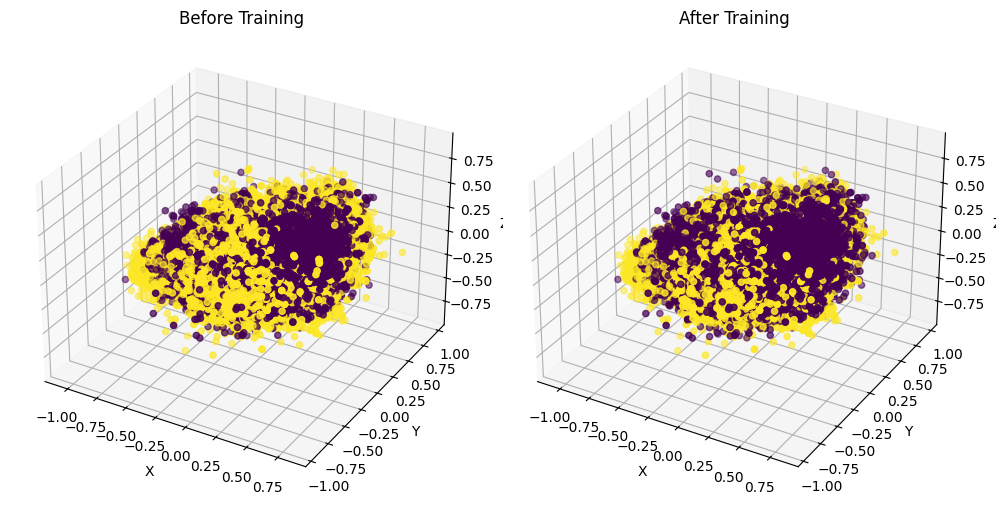

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))

# Before Training
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(embeddings_train[:, 0], embeddings_train[:, 1], embeddings_train[:, 2], c=y_train, cmap='viridis')
ax1.set_title('Before Training')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# After Training
ax2 = fig.add_subplot(122, projection='3d')
with torch.no_grad():
    train_inputs_3d = torch.tensor(embeddings_train, dtype=torch.float32).to(device)
    train_outputs_3d = model(train_inputs_3d)
    _, train_predicted_3d = torch.max(train_outputs_3d, 1)
    ax2.scatter(embeddings_train[:, 0], embeddings_train[:, 1], embeddings_train[:, 2], c=train_predicted_3d.cpu().numpy(), cmap='viridis')
ax2.set_title('After Training')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [1]:
import torch

# Load the trained model
gpt0_model = NeuralNetwork(input_size, hidden_size, output_size)
gpt0_model.load_state_dict(torch.load("pkl_assets/gpt0.pth"))
gpt0_model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt0_model.to(device)

def gpt0_search(gpt0_model, model_input):

    def encode(model_input):
        embedding = model.encode([model_input])
        return embedding[0]

    def classify_text(model_input):
        encoded_text = encode(model_input)
        input_tensor = torch.tensor(encoded_text, dtype=torch.float32).unsqueeze(0).to(device)
        # Predict the label (human or AI) using the trained model
        with torch.no_grad():
            output = gpt0_model(input_tensor)
            _, prediction = torch.max(output, 1)

        return "AI-Generated" if prediction[0] == 1 else "Human-Generated"

    return classify_text(model_input)

model_input = """
To be fair, though, it still wouldn't be worth partitioning first,
because partitioning requires conditional copying or swapping based on the same array[i] > 128 compare.
(Unless you're going to be counting multiple times, and you want to partition the bulk of an array so it's still fast,
only mispredicting in an unpartitioned part after some appends or modifications).
If you can get the compiler to do it, ideally just vectorize with SIMD, or at least use branchless scalar if the data is unpredictable.
"""

classification_result = gpt0_search(gpt0_model, model_input)
print(f"This can be classified as: {classification_result}")

NameError: name 'NeuralNetwork' is not defined

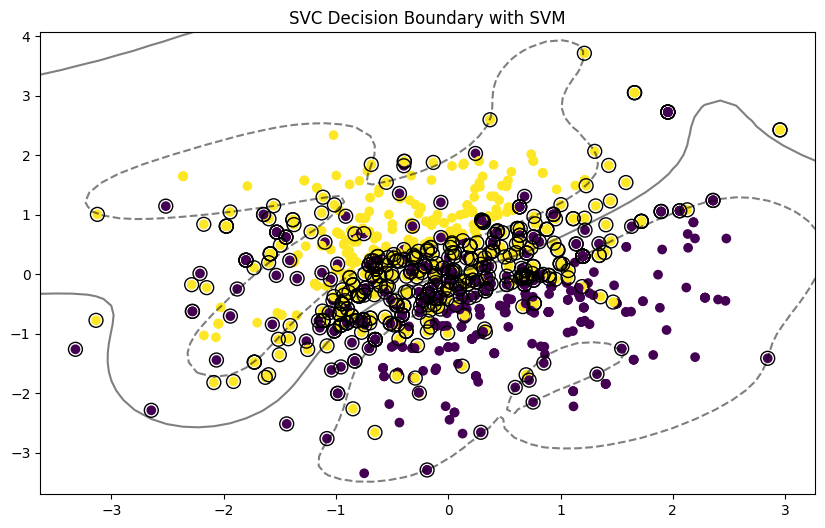

In [ ]:
# Choose two features to visualize
i, j = 0, 1

# Create a new training set using only the two selected features
X_train_2d = embeddings_train[:, [i, j]]

# Train a new SVC model on these two features for visualization
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train_2d, y_train)

# Plotting the decision boundary for the 2D dataset
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='viridis')

# Create grid to evaluate model
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Plot support vectors
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel('')
plt.ylabel('')
plt.title('SVC Decision Boundary with SVM')
plt.show()

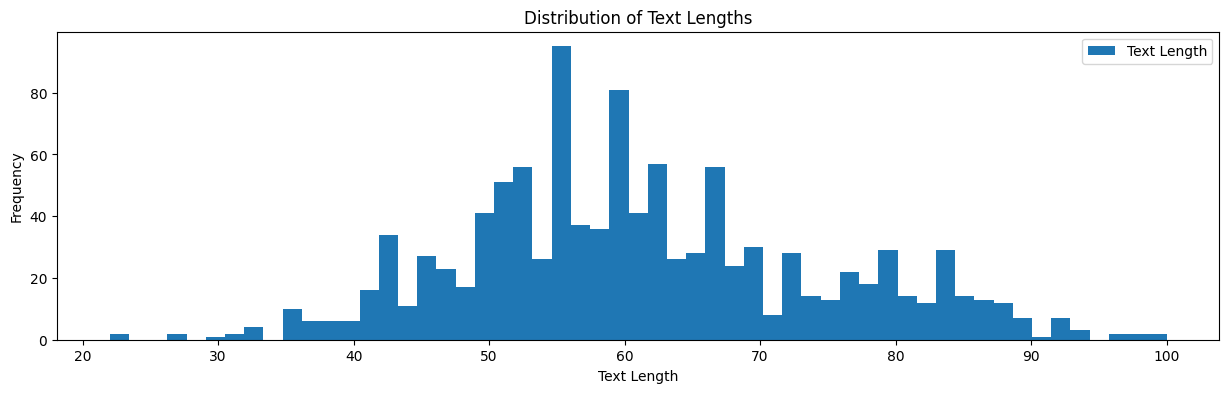

In [ ]:
# Adding a new column for text length
data['Text Length'] = data['Target'].apply(len)

# Plotting text length distributions
plt.figure(figsize=(15, 4))
plt.hist(data['Text Length'], bins = 55, alpha = 1.0, label = 'Text Length')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()